In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
from iminuit import Minuit
from pprint import pprint
from scipy.special import beta

# Load data

In [54]:
data = {}

dd = []
for i in [1,2,4,5,6,11,12,16,17,31,37,40,46,51,52,53,54,55]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['mu*G_Ep/G_Mp'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [7,9,14,21,23,26,29,35,38,76,78,79]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['G_Ep/G_D'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [8,10,13,15,18,22,24,27,30,36,39,80]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['G_Mp/mu/G_D'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [57,60,74]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['mu*G_En/G_Mn'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [41,42,43,44,45,47,48,49,50,56,58,59,61,81]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['G_En'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [20,62,63,64,65,66,67,68,69,70,72,73]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['G_Mn/mu/G_D'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [25,32]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['Q^4*F_1p'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [28,34]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['Q^2*F_2p/F_1p'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [33,]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))    
data['F_2p/G_D'] = pd.concat(dd, ignore_index=True)

dd = []
for i in [75,77]:
    dd.append(pd.read_table('expdata/r{:0>4d}.dat'.format(i), delim_whitespace=True))
data['sigma/sigma_D'] = pd.concat(dd, ignore_index=True)

# Funcitons

In [55]:
def G_D(Q2):
    return (1.0 + Q2/0.71)**(-2)

In [56]:
def alphat(t, kappa, a0):
    return t / (4.0 * kappa**2) + a0

In [57]:
class Parameters:    
    kappa = 0.533663
    lam = kappa**2
    a0rho = 0.492113
    a0omega = 0.5
    a0phi = 0.014219
    a0 = 0.5 - 0.1349770**2 / (4.0 * kappa**2)
    mup = 2.7928473446
    kap = mup - 1.0
    mun = -1.9130427
    kan = mun
    Mp = 0.938272081
    Mn = 0.939565413
    
    def __int__(self):
        pass
    
    def reset(self):
        self.kappa = Parameters.kappa
        self.a0 = Parameters.a0
    
    def sample(self):
        self.kappa = Parameters.kappa * np.random.normal(1.0, 0.05)
        self.a0 = 0.5 - 0.1349770**2 / (4.0 * self.kappa**2)
        
    
Par = Parameters()

In [ ]:
class Coef:
    u3 = 2.0
    u4 = 0.0
    u5 = 0.0
    u6 = 0.0
    d3 = 1.0
    d4 = 0.0
    d5 = 0.0
    d6 = 0.0
    

In [58]:
def FF(tau, Q2, kappa = None, a0 = None):
    if kappa == None:
        kappa = Par.kappa
    if a0 == None:
        a0 = Par.a0
    return beta(tau - 1.0, 1.0 - alphat(-Q2, kappa, a0)) / beta(tau - 1.0, 1.0 - a0)

def FFiv(tau, Q2):
    return FF(tau, Q2, Par.kappa, Par.a0rho)

def FFis(tau, Q2):
    return FF(tau, Q2, Par.kappa, Par.a0omega)

def FFs(tau, Q2):
    return FF(tau, Q2, Par.kappa, Par.a0phi)

In [59]:
Par.reset()
print Par.kappa, Par.a0

0.533663 0.484007168385


# Fit: 

## Proton

In [60]:
def F1p(Q2, par):
    a4 = par[0]
    a5 = par[1]
    a6 = par[2]
    a3 = 1.0 - a4 - a5 - a6
    return a3 * FF(3, Q2) + a4 * FF(4, Q2) + a5 * FF(5, Q2) + a6 * FF(6, Q2)

def F2p(Q2, par):
    b6 = par[3]
    b4 = 1.0 - b6
    return (b4 * FF(4, Q2) + b6 * FF(6, Q2)) * Par.kap

def GEp(Q2, par):
    return F1p(Q2, par) - Q2 / (4.0 * Par.Mp**2) * F2p(Q2, par)

def GMp(Q2, par):
    return F1p(Q2, par) + F2p(Q2, par)

def sigmaratio(Q2, epsilon, par):
    t = Q2 / (4.0 * Par.Mp**2)
    return (epsilon * GEp(Q2, par)**2 + t * GMp(Q2, par)**2) / (epsilon * G_D(Q2)**2 + t * (Par.mup * G_D(Q2))**2)

In [72]:
Q2l, Q2u = 0.0, np.inf
wp = 0.0
eth = 0.05
def Chi2(par):
    result = 0.0
    Data = data['mu*G_Ep/G_Mp'][np.logical_and(Q2l < data['mu*G_Ep/G_Mp']['Q2'], data['mu*G_Ep/G_Mp']['Q2'] < Q2u)]
    Q2, value, error = Data['Q2'], Data['mu*G_Ep/G_Mp'], Data['error']
    thy = Par.mup * GEp(Q2, par) / GMp(Q2, par)
    result += np.sum((thy - value)**2 / (error**2 + (value*eth)**2) * Q2**wp)
    ##
    Data = data['G_Ep/G_D'][np.logical_and(Q2l < data['G_Ep/G_D']['Q2'], data['G_Ep/G_D']['Q2'] < Q2u)]
    Q2, value, error = Data['Q2'], Data['G_Ep/G_D'], Data['error']
    thy = GEp(Q2, par) / G_D(Q2)
    result += np.sum((thy - value)**2 / (error**2 + (value*eth)**2) * Q2**wp)
    ##
    Data = data['G_Mp/mu/G_D'][np.logical_and(Q2l < data['G_Mp/mu/G_D']['Q2'], data['G_Mp/mu/G_D']['Q2'] < Q2u)]
    Q2, value, error = Data['Q2'], Data['G_Mp/mu/G_D'], Data['error']
    thy = GMp(Q2, par) / Par.mup / G_D(Q2)
    result += np.sum((thy - value)**2 / (error**2 + (value*eth)**2) * Q2**wp)
    ##
    Data = data['Q^4*F_1p'][np.logical_and(Q2l < data['Q^4*F_1p']['Q2'], data['Q^4*F_1p']['Q2'] < Q2u)]
    Q2, value, error = Data['Q2'], Data['Q^4*F_1p'], Data['error']
    thy = Q2**2 * F1p(Q2, par)
    result += np.sum((thy - value)**2 / (error**2 + (value*eth)**2) * Q2**wp)
    Data = data['Q^2*F_2p/F_1p'][np.logical_and(Q2l < data['Q^2*F_2p/F_1p']['Q2'], data['Q^2*F_2p/F_1p']['Q2'] < Q2u)]
    Q2, value, error = Data['Q2'], Data['Q^2*F_2p/F_1p'], Data['error']
    thy = Q2 * F2p(Q2, par) / F1p(Q2, par) / Par.kap
    result += np.sum((thy - value)**2 / (error**2 + (value*eth)**2) * Q2**wp)
    Data = data['F_2p/G_D'][np.logical_and(Q2l < data['F_2p/G_D']['Q2'], data['F_2p/G_D']['Q2'] < Q2u)]
    Q2, value, error = Data['Q2'], Data['F_2p/G_D'], Data['error']
    thy = F2p(Q2, par) / G_D(Q2) / Par.kap
    result += np.sum((thy - value)**2 / (error**2 + (value*eth)**2) * Data['Q2']**wp)
    return result
    

In [79]:
Par.kappa = Parameters.kappa
Min1p = Minuit.from_array_func(Chi2, start = (-0.2, 0.0, 0.0, 0.0, 3.0),\
                            name = ('a4', 'a5', 'a6', 'b6', 'none'),\
                            error = (0.01, 0.01, 0.01, 0.01, 0.01),\
                            errordef = 1,\
                            fix = (False, True, True, False, True),\
                            limit = ((None, None), (0, None), (0, None), (None, None), (None, None)))

In [80]:
Par.reset()
Min1p.tol = 1e-4
fmin, fpar = Min1p.migrad(ncall=10000)

FCN = 613.858694 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 4.02784539805e-09 
 GOAL EDM = 1e-08 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a4,-0.091678,0.0117013,,,,,No
1,a5,0,0.01,,,0,,Yes
2,a6,0,0.01,,,0,,Yes
3,b6,0.35585,0.00969187,,,,,No
4,none,3,0.01,,,,,Yes


In [28]:
Par.reset()
Min = Minuit.from_array_func(Chi2, start = (0.0, 0.0, 0.0, 0.0, 3.0),\
                            name = ('a4', 'a5', 'a6', 'b6', 'tw'),\
                            error = (0.01, 0.01, 0.01, 0.01, 0.01),\
                            errordef = 1,\
                            fix = (False, True, True, False, True),\
                            limit = ((None, None), (None, None), (None, None), (None, None), (2, 3)),\
                            print_level = 0)
df = pd.DataFrame(columns=['kappa', 'a4', 'a5', 'a6', 'b6'])
for i in range(200):
    Min.migrad(ncall=1000)
    Min.migrad(ncall=1000)
    df = df.append({'kappa': Par.kappa,\
               'a4': Min.values['a4'],\
               'a5': Min.values['a5'],\
               'a6': Min.values['a6'],\
               'b6': Min.values['b6']}, ignore_index = True)
    Par.kappa = Parameters.kappa * np.random.normal(1.0, 0.05)
    Par.a0 = 0.5 - 0.1349770**2 / (4.0 * Par.kappa**2)
    print i, "%.4f %.4f %.4f    \r"%(Par.kappa, Min.values['a4'], Min.values['b6']), 
    
df.to_csv('results/parameters1.dat', sep = '\t', index = False)

In [29]:
def get_theory_p(Q2, df):
    thy = pd.DataFrame(columns=['mu*G_Ep/G_Mp',  'G_Ep/G_D', 'G_Mp/mu/G_D',\
                                'Q^4*F_1p', 'Q^2*F_2p/F_1p', 'F_2p/G_D'])
    for i in range(len(df)):
        Par.kappa = df.loc[i]['kappa']
        Par.a0 = 0.5 - 0.1349770**2 / (4.0 * Par.kappa**2)
        par = df.loc[i].values[1:]
        thy = thy.append({'mu*G_Ep/G_Mp': Par.mup * GEp(Q2, par) / GMp(Q2, par),\
                          'G_Ep/G_D': GEp(Q2, par) / G_D(Q2),\
                          'G_Mp/mu/G_D': GMp(Q2, par) / Par.mup / G_D(Q2),\
                          'Q^4*F_1p': Q2**2 * F1p(Q2, par),\
                          'Q^2*F_2p/F_1p': Q2 * F2p(Q2, par) / F1p(Q2, par) / Par.kap,\
                          'F_2p/G_D': F2p(Q2, par) / G_D(Q2) / Par.kap}, ignore_index=True)
    res = {'Q2': Q2,\
           'mu*G_Ep/G_Mp': thy['mu*G_Ep/G_Mp'].values.mean(), 'dmu*G_Ep/G_Mp': thy['mu*G_Ep/G_Mp'].values.std(),\
           'G_Ep/G_D': thy['G_Ep/G_D'].values.mean(), 'dG_Ep/G_D': thy['G_Ep/G_D'].values.std(),\
           'G_Mp/mu/G_D': thy['G_Mp/mu/G_D'].values.mean(), 'dG_Mp/mu/G_D': thy['G_Mp/mu/G_D'].values.std(),\
           'Q^4*F_1p': thy['Q^4*F_1p'].values.mean(), 'dQ^4*F_1p': thy['Q^4*F_1p'].values.std(),\
           'Q^2*F_2p/F_1p': thy['Q^2*F_2p/F_1p'].values.mean(), 'dQ^2*F_2p/F_1p': thy['Q^2*F_2p/F_1p'].values.std(),\
           'F_2p/G_D': thy['F_2p/G_D'].values.mean(), 'dF_2p/G_D': thy['F_2p/G_D'].values.std()}
    return res

NameError: name 'GEn' is not defined

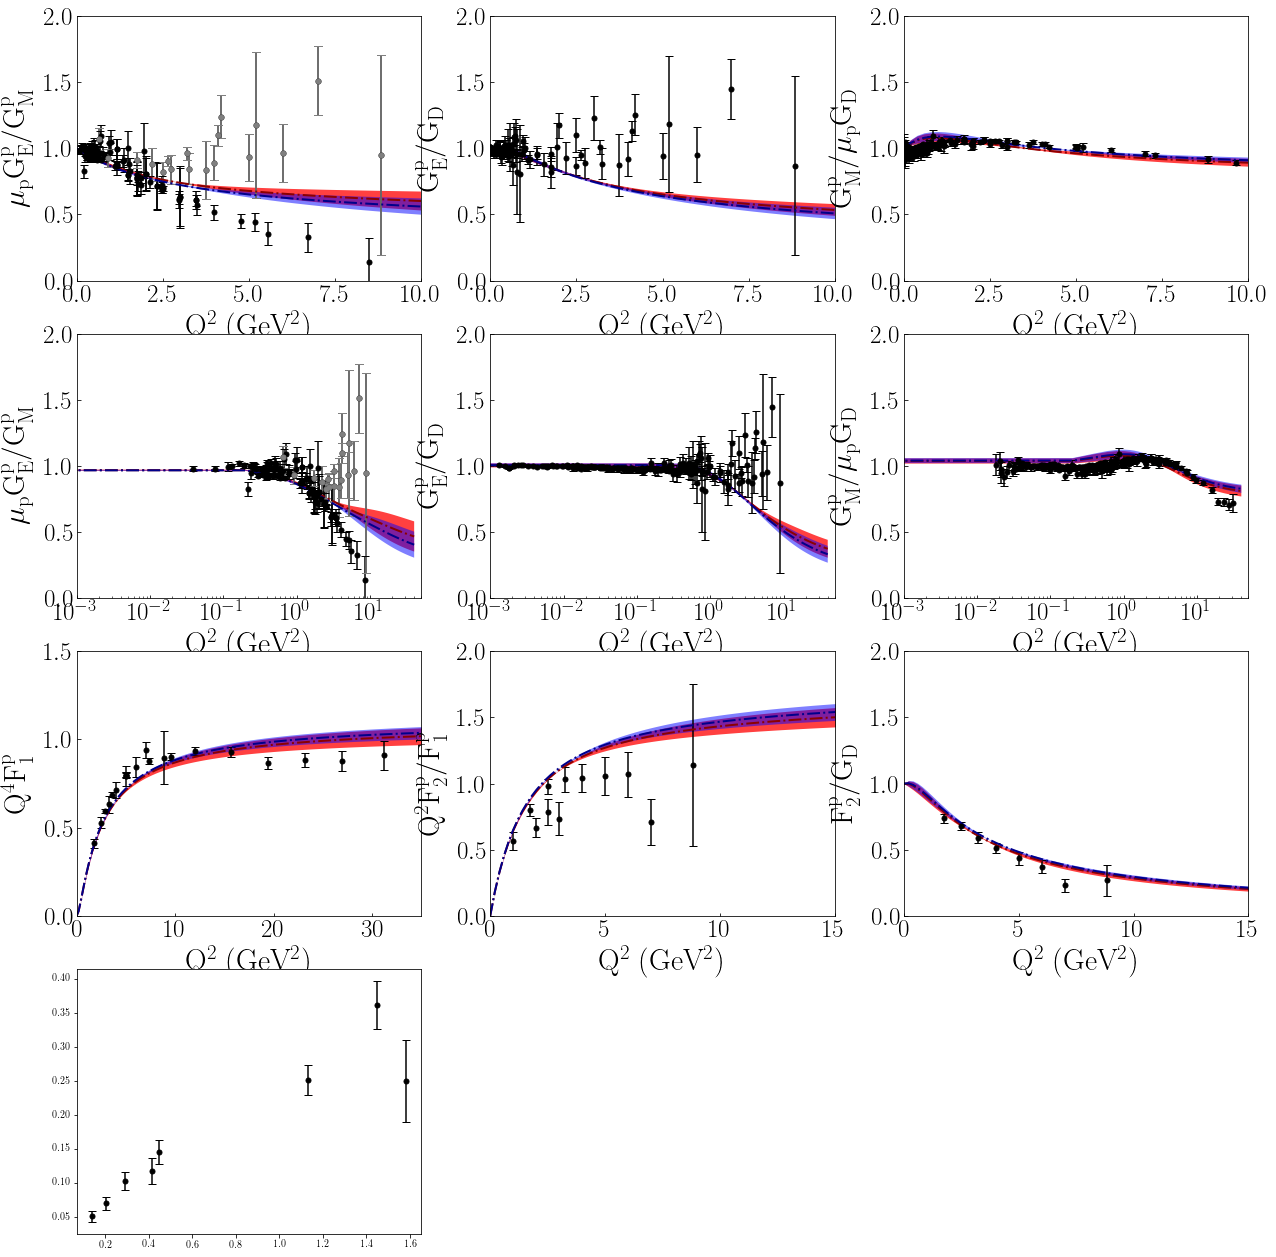

In [96]:
nrows, ncols = 4, 3
fig = plt.figure(figsize=(ncols*7, nrows*7*0.8))

Q2 = np.linspace(0, 40, 200)
df0 = pd.read_table('results/parameters0.dat', delim_whitespace=True)
df1 = pd.read_table('results/parameters1.dat', delim_whitespace=True)
res0 = get_theory_p(Q2, df0)
res1 = get_theory_p(Q2, df1)

Par.reset()
par2 = np.array([-0.281633, 0.0, 0.0, 0.0, 3.0])

sglr1 = pd.read_table('expdata/r0031.dat', delim_whitespace=True)
sglr2 = pd.read_table('expdata/r0037.dat', delim_whitespace=True)
sglr3 = pd.read_table('expdata/r0040.dat', delim_whitespace=True)

ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['mu*G_Ep/G_Mp']['Q2'], data['mu*G_Ep/G_Mp']['mu*G_Ep/G_Mp'], yerr=data['mu*G_Ep/G_Mp']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.errorbar(sglr1['Q2'], sglr1['mu*G_Ep/G_Mp'], yerr=sglr1['error'],\
           linestyle = '', color = 'gray', marker = 'o', markersize = 5, capsize = 4)
ax.errorbar(sglr2['Q2'], sglr2['mu*G_Ep/G_Mp'], yerr=sglr2['error'],\
           linestyle = '', color = 'gray', marker = 'o', markersize = 5, capsize = 4)
ax.errorbar(sglr3['Q2'], sglr3['mu*G_Ep/G_Mp'], yerr=sglr3['error'],\
           linestyle = '', color = 'gray', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, Par.mup * GEp(Q2, par2) / GMp(Q2, par2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['mu*G_Ep/G_Mp'] - res0['dmu*G_Ep/G_Mp'], res0['mu*G_Ep/G_Mp'] + res0['dmu*G_Ep/G_Mp'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['mu*G_Ep/G_Mp'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['mu*G_Ep/G_Mp'] - res1['dmu*G_Ep/G_Mp'], res1['mu*G_Ep/G_Mp'] + res1['dmu*G_Ep/G_Mp'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['mu*G_Ep/G_Mp'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-4, 10)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm\mu_pG_E^p/G_M^p$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['G_Ep/G_D']['Q2'], data['G_Ep/G_D']['G_Ep/G_D'], yerr=data['G_Ep/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, GEp(Q2, par2) / G_D(Q2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['G_Ep/G_D'] - res0['dG_Ep/G_D'], res0['G_Ep/G_D'] + res0['dG_Ep/G_D'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['G_Ep/G_D'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['G_Ep/G_D'] - res1['dG_Ep/G_D'], res1['G_Ep/G_D'] + res1['dG_Ep/G_D'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['G_Ep/G_D'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-4, 10)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_E^p/G_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 3)
ax.errorbar(data['G_Mp/mu/G_D']['Q2'], data['G_Mp/mu/G_D']['G_Mp/mu/G_D'], yerr=data['G_Mp/mu/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, GMp(Q2, par2) / Par.mup / G_D(Q2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['G_Mp/mu/G_D'] - res0['dG_Mp/mu/G_D'], res0['G_Mp/mu/G_D'] + res0['dG_Mp/mu/G_D'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['G_Mp/mu/G_D'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['G_Mp/mu/G_D'] - res1['dG_Mp/mu/G_D'], res1['G_Mp/mu/G_D'] + res1['dG_Mp/mu/G_D'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['G_Mp/mu/G_D'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-4, 10)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_M^p/\mu_pG_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 4)
ax.errorbar(data['mu*G_Ep/G_Mp']['Q2'], data['mu*G_Ep/G_Mp']['mu*G_Ep/G_Mp'], yerr=data['mu*G_Ep/G_Mp']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.errorbar(sglr1['Q2'], sglr1['mu*G_Ep/G_Mp'], yerr=sglr1['error'],\
           linestyle = '', color = 'gray', marker = 'o', markersize = 5, capsize = 4)
ax.errorbar(sglr2['Q2'], sglr2['mu*G_Ep/G_Mp'], yerr=sglr2['error'],\
           linestyle = '', color = 'gray', marker = 'o', markersize = 5, capsize = 4)
ax.errorbar(sglr3['Q2'], sglr3['mu*G_Ep/G_Mp'], yerr=sglr3['error'],\
           linestyle = '', color = 'gray', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, Par.mup * GEp(Q2, par2) / GMp(Q2, par2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['mu*G_Ep/G_Mp'] - res0['dmu*G_Ep/G_Mp'], res0['mu*G_Ep/G_Mp'] + res0['dmu*G_Ep/G_Mp'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['mu*G_Ep/G_Mp'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['mu*G_Ep/G_Mp'] - res1['dmu*G_Ep/G_Mp'], res1['mu*G_Ep/G_Mp'] + res1['dmu*G_Ep/G_Mp'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['mu*G_Ep/G_Mp'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-3, 50)
ax.set_xscale('log')
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm\mu_pG_E^p/G_M^p$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 5)
ax.errorbar(data['G_Ep/G_D']['Q2'], data['G_Ep/G_D']['G_Ep/G_D'], yerr=data['G_Ep/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, GEp(Q2, par2) / G_D(Q2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['G_Ep/G_D'] - res0['dG_Ep/G_D'], res0['G_Ep/G_D'] + res0['dG_Ep/G_D'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['G_Ep/G_D'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['G_Ep/G_D'] - res1['dG_Ep/G_D'], res1['G_Ep/G_D'] + res1['dG_Ep/G_D'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['G_Ep/G_D'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-3, 50)
ax.set_xscale('log')
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_E^p/G_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 6)
ax.errorbar(data['G_Mp/mu/G_D']['Q2'], data['G_Mp/mu/G_D']['G_Mp/mu/G_D'], yerr=data['G_Mp/mu/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, GMp(Q2, par2) / Par.mup / G_D(Q2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['G_Mp/mu/G_D'] - res0['dG_Mp/mu/G_D'], res0['G_Mp/mu/G_D'] + res0['dG_Mp/mu/G_D'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['G_Mp/mu/G_D'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['G_Mp/mu/G_D'] - res1['dG_Mp/mu/G_D'], res1['G_Mp/mu/G_D'] + res1['dG_Mp/mu/G_D'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['G_Mp/mu/G_D'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-3, 50)
ax.set_xscale('log')
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_M^p/\mu_pG_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 7)
ax.errorbar(data['Q^4*F_1p']['Q2'], data['Q^4*F_1p']['Q^4*F_1p'], yerr=data['Q^4*F_1p']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, Q2**2 * F1p(Q2, par2),\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['Q^4*F_1p'] - res0['dQ^4*F_1p'], res0['Q^4*F_1p'] + res0['dQ^4*F_1p'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['Q^4*F_1p'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['Q^4*F_1p'] - res1['dQ^4*F_1p'], res1['Q^4*F_1p'] + res1['dQ^4*F_1p'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['Q^4*F_1p'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-4, 35)
ax.set_ylim(0, 1.5)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm Q^4 F_1^p$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 8)
ax.errorbar(data['Q^2*F_2p/F_1p']['Q2'], data['Q^2*F_2p/F_1p']['Q^2*F_2p/F_1p'], yerr=data['Q^2*F_2p/F_1p']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, Q2 * F2p(Q2, par2) / F1p(Q2, par2) / Par.kap,\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['Q^2*F_2p/F_1p'] - res0['dQ^2*F_2p/F_1p'], res0['Q^2*F_2p/F_1p'] + res0['dQ^2*F_2p/F_1p'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['Q^2*F_2p/F_1p'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['Q^2*F_2p/F_1p'] - res1['dQ^2*F_2p/F_1p'], res1['Q^2*F_2p/F_1p'] + res1['dQ^2*F_2p/F_1p'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['Q^2*F_2p/F_1p'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-4, 15)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm Q^2 F_2^p/F_1^p$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 9)
ax.errorbar(data['F_2p/G_D']['Q2'], data['F_2p/G_D']['F_2p/G_D'], yerr=data['F_2p/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
#ax.plot(Q2, F2p(Q2, par2) / G_D(Q2) / Par.kap,\
#       linestyle = '--', color = 'green', linewidth = 2)
ax.fill_between(res0['Q2'], res0['F_2p/G_D'] - res0['dF_2p/G_D'], res0['F_2p/G_D'] + res0['dF_2p/G_D'],\
                linewidth = 0, color = 'red', alpha = 0.75)
ax.plot(res0['Q2'], res0['F_2p/G_D'], linestyle = '-.', linewidth = 2, color = 'darkred')
ax.fill_between(res1['Q2'], res1['F_2p/G_D'] - res1['dF_2p/G_D'], res1['F_2p/G_D'] + res1['dF_2p/G_D'],\
                linewidth = 0, color = 'blue', alpha = 0.5)
ax.plot(res1['Q2'], res1['F_2p/G_D'], linestyle = '-.', linewidth = 2, color = 'darkblue')
ax.set_xlim(1e-4, 15)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm F_2^p/G_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 10)
ax.errorbar(data['mu*G_En/G_Mn']['Q2'], data['mu*G_En/G_Mn']['mu*G_En/G_Mn'], yerr=data['mu*G_En/G_Mn']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.plot(Q2, Par.mun * GEn(Q2) / GMn(Q2),\
       linestyle = '-', color = 'red', linewidth = 2)
ax.set_xlim(1e-4, 5)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm\mu_nG_E^n/G_M^n$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 11)
ax.errorbar(data['G_En']['Q2'], data['G_En']['G_En'], yerr=data['G_En']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.plot(Q2, GEn(Q2),\
       linestyle = '-', color = 'red', linewidth = 2)
ax.set_xlim(1e-4, 5)
ax.set_ylim(0, 0.2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_E^n$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 12)
ax.errorbar(data['G_Mn/mu/G_D']['Q2'], data['G_Mn/mu/G_D']['G_Mn/mu/G_D'], yerr=data['G_Mn/mu/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.plot(Q2, GMn(Q2) / Par.mun / G_D(Q2),\
       linestyle = '-', color = 'red', linewidth = 2)
ax.set_xlim(1e-4, 12)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_M^n/\mu_n G_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)


fig.tight_layout()
#fig.savefig('plots/emff.pdf')

In [95]:
print df0.mean()
print df0.std()
print df1.mean()
print df1.std()

kappa    0.533214
a4      -0.114178
a5       0.000000
a6       0.000000
b6       0.306917
dtype: float64
kappa    0.026054
a4       0.284497
a5       0.000000
a6       0.000000
b6       0.261148
dtype: float64
kappa    0.534536
a4      -0.119175
a5       0.000000
a6       0.000000
b6       0.292740
dtype: float64
kappa    0.024568
a4       0.254001
a5       0.000000
a6       0.000000
b6       0.237176
dtype: float64


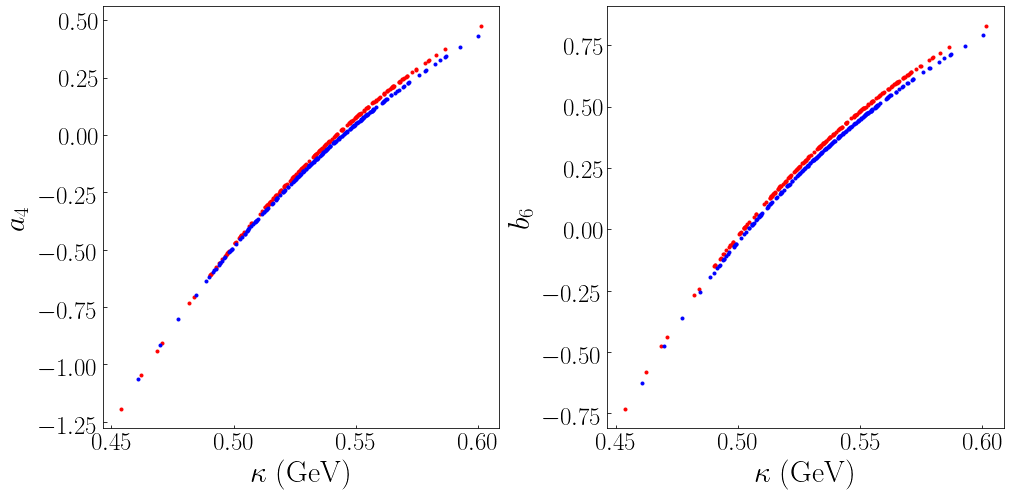

In [92]:
nrows, ncols = 1, 2

fig = plt.figure(figsize=(ncols*7, nrows*7))

ax = fig.add_subplot(nrows, ncols, 1)
ax.plot(df0['kappa'], df0['a4'], marker = '.', linestyle = '', color = 'red')
ax.plot(df1['kappa'], df1['a4'], marker = '.', linestyle = '', color = 'blue')
#ax.set_xlim(0.42, 0.62)
#ax.set_ylim(-1.25, 0.75)
ax.set_xlabel(r'$\rm \kappa~(GeV)$', size = 30)
ax.set_ylabel(r'$a_4$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize =25)

ax = fig.add_subplot(nrows, ncols, 2)
ax.plot(df0['kappa'], df0['b6'], marker = '.', linestyle = '', color = 'red')
ax.plot(df1['kappa'], df1['b6'], marker = '.', linestyle = '', color = 'blue')
#ax.set_xlim(0.42, 0.62)
#ax.set_ylim(-1.25, 0.75)
ax.set_xlabel(r'$\rm \kappa~(GeV)$', size = 30)
ax.set_ylabel(r'$b_6$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize =25)

fig.tight_layout()
fig.savefig('results/par.pdf')

## Neutron

In [38]:
def F1n(Q2, par):
    a4 = par[0]
    a5 = par[1]
    a6 = -a5
    a3 = -a4 - a5 - a6
    return a3 * FF(3, Q2) + a4 * FF(4, Q2) + a5 * FF(5, Q2) + a6 * FF(6, Q2)

def F2n(Q2, par):
    b6 = par[3]
    b4 = 1.0 - b6
    return (b4 * FF(4, Q2) + b6 * FF(6, Q2)) * Par.kan

def GEn(Q2, par):
    return F1n(Q2, par) - Q2 / (4.0 * Par.Mn**2) * F2n(Q2, par)

def GMn(Q2, par):
    return F1n(Q2, par) + F2n(Q2, par)

In [39]:
Q2cut = 0.0
def Chi2(par):
    result = 0.0
    Data = data['mu*G_En/G_Mn'][data['mu*G_En/G_Mn']['Q2']>Q2cut]
    thy = Par.mun * GEn(Data['Q2'], par) / GMn(Data['Q2'], par)
    result += np.sum(np.power((thy - Data['mu*G_En/G_Mn']) / Data['error'], 2))
    Data = data['G_En'][data['G_En']['Q2']>Q2cut]
    thy = GEn(Data['Q2'], par)
    result += np.sum(np.power((thy - Data['G_En']) / Data['error'], 2))
    Data = data['G_Mn/mu/G_D'][data['G_Mn/mu/G_D']['Q2']>Q2cut]
    thy = GMn(Data['Q2'], par) / Par.mun / G_D(Data['Q2'])
    result += np.sum(np.power((thy - Data['G_Mn/mu/G_D']) / Data['error'], 2))
    return result

In [45]:
Par.kappa = Parameters.kappa
Min1n = Minuit.from_array_func(Chi2, start = (0.5920235, 0.0, 0.0, 0.0),\
                             name = ('a4', 'a5', 'a6', 'b6'),\
                             error = (0.1, 0.1, 0.1, 0.1),\
                             fix = (True, True, True, False),\
                             limit = ((None, None), (None, None), (None, None), (None, None)),\
                             errordef = 1)

fmin, fpar = Min1n.migrad()

FCN = 605.653993905 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 1.13230101754e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a4,0.592024,0.1,,,,,Yes
1,a5,0,0.1,,,,,Yes
2,a6,0,0.1,,,,,Yes
3,b6,0.106416,0.00931633,,,,,No


In [46]:
Par.kappa = Parameters.kappa
Min2n = Minuit.from_array_func(Chi2, start = (0.6001275, 0.0, 0.0, 0.0),\
                             name = ('a4', 'a5', 'a6', 'b6'),\
                             error = (0.1, 0.1, 0.1, 0.1),\
                             fix = (True, True, True, False),\
                             limit = ((None, None), (None, None), (None, None), (None, None)),\
                             errordef = 1)

fmin, fpar = Min2n.migrad()

FCN = 588.762758502 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 1.47087402919e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a4,0.600128,0.1,,,,,Yes
1,a5,0,0.1,,,,,Yes
2,a6,0,0.1,,,,,Yes
3,b6,0.111223,0.00931542,,,,,No


In [52]:
Par.kappa = Parameters.kappa
Min3n = Minuit.from_array_func(Chi2, start = (0.6001275, 0.0, 0.0, 0.0),\
                             name = ('a4', 'a5', 'a6', 'b6'),\
                             error = (0.1, 0.1, 0.1, 0.1),\
                             fix = (False, True, True, False),\
                             limit = ((None, None), (None, None), (None, None), (None, None)),\
                             errordef = 1)

fmin, fpar = Min3n.migrad()

FCN = 459.885075795 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.65395004697e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a4,0.727715,0.011239,,,,,No
1,a5,0,0.1,,,,,Yes
2,a6,0,0.1,,,,,Yes
3,b6,0.186223,0.0113809,,,,,No


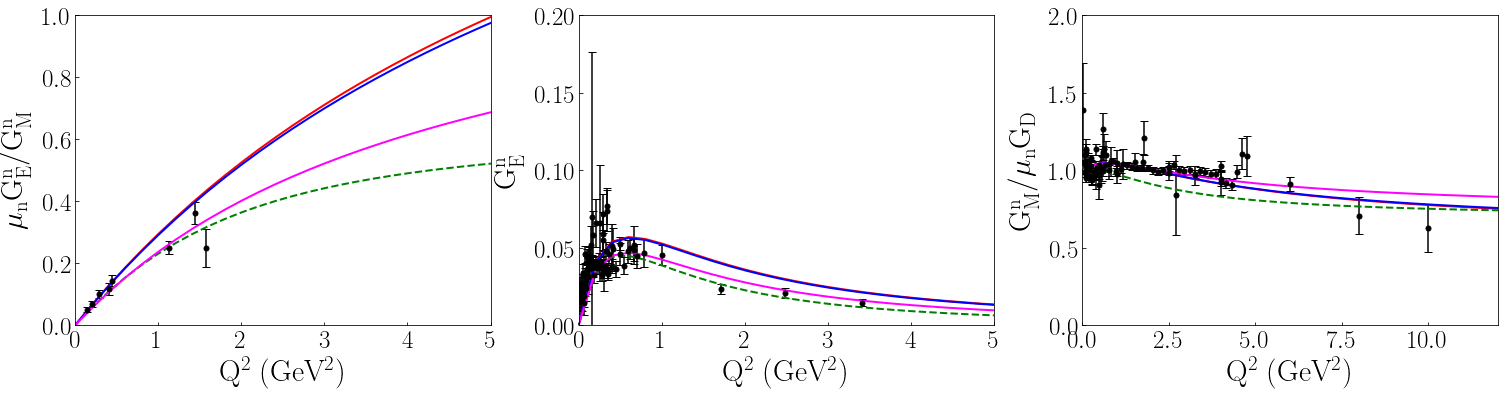

In [56]:
nrows, ncols = 1, 3
fig = plt.figure(figsize=(ncols*7, nrows*7*0.8))
Q2 = np.linspace(0, 40, 200)

par0 = Min1n.np_values()
par1 = Min2n.np_values()
par3 = Min3n.np_values()
par2 = [2.08/3, 0.0, 0.0, 0.38]

ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['mu*G_En/G_Mn']['Q2'], data['mu*G_En/G_Mn']['mu*G_En/G_Mn'], yerr=data['mu*G_En/G_Mn']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.plot(Q2, Par.mun * GEn(Q2, par2) / GMn(Q2, par2),\
       linestyle = '--', color = 'green', linewidth = 2)
ax.plot(Q2, Par.mun * GEn(Q2, par0) / GMn(Q2, par0),\
       linestyle = '-', color = 'red', linewidth = 2)
ax.plot(Q2, Par.mun * GEn(Q2, par1) / GMn(Q2, par1),\
       linestyle = '-', color = 'blue', linewidth = 2)
ax.plot(Q2, Par.mun * GEn(Q2, par3) / GMn(Q2, par3),\
       linestyle = '-', color = 'magenta', linewidth = 2)
ax.set_xlim(1e-4, 5)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm\mu_nG_E^n/G_M^n$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['G_En']['Q2'], data['G_En']['G_En'], yerr=data['G_En']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.plot(Q2, GEn(Q2, par2),\
       linestyle = '--', color = 'green', linewidth = 2)
ax.plot(Q2, GEn(Q2, par0),\
       linestyle = '-', color = 'red', linewidth = 2)
ax.plot(Q2, GEn(Q2, par1),\
       linestyle = '-', color = 'blue', linewidth = 2)
ax.plot(Q2, GEn(Q2, par3),\
       linestyle = '-', color = 'magenta', linewidth = 2)
ax.set_xlim(1e-4, 5)
ax.set_ylim(0, 0.2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_E^n$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)

ax = fig.add_subplot(nrows, ncols, 3)
ax.errorbar(data['G_Mn/mu/G_D']['Q2'], data['G_Mn/mu/G_D']['G_Mn/mu/G_D'], yerr=data['G_Mn/mu/G_D']['error'],\
           linestyle = '', color = 'black', marker = 'o', markersize = 5, capsize = 4)
ax.plot(Q2, GMn(Q2, par2) / Par.mun / G_D(Q2),\
       linestyle = '--', color = 'green', linewidth = 2)
ax.plot(Q2, GMn(Q2, par0) / Par.mun / G_D(Q2),\
       linestyle = '-', color = 'red', linewidth = 2)
ax.plot(Q2, GMn(Q2, par1) / Par.mun / G_D(Q2),\
       linestyle = '-', color = 'blue', linewidth = 2)
ax.plot(Q2, GMn(Q2, par3) / Par.mun / G_D(Q2),\
       linestyle = '-', color = 'magenta', linewidth = 2)
ax.set_xlim(1e-4, 12)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$\rm Q^2~(GeV^2)$', size=30)
ax.set_ylabel(r'$\rm G_M^n/\mu_n G_D$', size=30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)


fig.tight_layout()
fig.savefig('plots/ffn.pdf')

In [57]:
Par.kappa

0.535994

In [58]:
Par.a0

0.5136270000000001

In [64]:
1/0.8767**0.5/2

0.5340039888110923